# **House sale prices**

## Objectives

* Evaluate multiple machine learning models to predict house prices.
* Use the prepared and transformed data created in previous steps (DataCollection, DataCleaning, and FeatureEngineering).
* Compare model performance to identify the best-performing model.

## Inputs

* Dataset with house prices that has gone through **data cleaning** and **feature engineering** (HousePricesFeatures.csv).
* Libraries for machine learning and data handling, including:
  - **pandas** for data manipulation.
  - **sklearn** for machine learning and model training.
  - **matplotlib** and **seaborn** for visualizations.

## Outputs

* Performance metrics for multiple trained machine learning models.
* Visualizations showing model predictions and errors for comparison.
* Identification of the best-performing model for further optimization.

### Note on Dataset Usage
This notebook uses the preprocessed dataset (`HousePricesFeatures.csv`) created in the `FeatureEngineering.ipynb` file. No additional transformations or modifications are made to the dataset in this step. The focus of this notebook is on:
- Training multiple machine learning models to evaluate their baseline performance.
- Comparing models based on metrics such as R2, Cross-Validation and Mean Absolute Error (MAE).
- Preparing for hyperparameter optimization, which is performed in Sales-price-prediction.ipynb.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [20]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [21]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [22]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
import json
import xgboost as xgb

# Load data

In [2]:
# Load pipeline and dataset
pipeline = load("outputs/pipelines/feature_pipeline_cleaned.pkl")
df_transformed = pd.read_csv("outputs/datasets/collection/HousePricesPredictionFeatures_Cleaned.csv")

# Confirm the dataset is loaded correctly
print("Dataset loaded successfully.")
print(f"Dataset shape: {df_transformed.shape}")
print("Sample of loaded data:")
print(df_transformed.head())

# Define features and target variable
X = df_transformed.drop(columns=['SalePrice'])
y = df_transformed['SalePrice']

Dataset loaded successfully.
Dataset shape: (1460, 6)
Sample of loaded data:
   GarageArea  GrLivArea  TotalBsmtSF  OverallQual  YearRemodAdd  SalePrice
0  204.517915   0.370333    -0.459303          7.0        2003.0   208500.0
1  177.329636  -0.482512     0.466465          6.0        1976.0   181500.0
2  222.579733   0.515013    -0.313369          7.0        2002.0   223500.0
3  232.664362   0.383659    -0.687324          7.0        1970.0   140000.0
4  288.451992   1.299326     0.199680          8.0        2000.0   250000.0


Define features and target variable

In [3]:
# Define features (X) and target (y) from df_transformed
X = df_transformed.drop('SalePrice', axis=1)
y = df_transformed['SalePrice']

# Confirm shapes
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (1460, 5)
Target shape: (1460,)


Split Data into Training and Testing Sets

In [4]:
# Train-test split with transformed features and original target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Log the shapes of the splits for confirmation
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

X_train.to_csv('outputs/pipelines/train-test/v1/X_train.csv', index=False)
X_test.to_csv('outputs/pipelines/train-test/v1/X_test.csv', index=False)
y_train.to_csv('outputs/pipelines/train-test/v1/y_train.csv', index=False)
y_test.to_csv('outputs/pipelines/train-test/v1/y_test.csv', index=False)


Training features shape: (1022, 5)
Testing features shape: (438, 5)
Training target shape: (1022,)
Testing target shape: (438,)


Create a machine learning pipeline (**Linear Regression**)

In [5]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale the features
    ('model', LinearRegression())  # Model to train
])

# Perform cross-validation on Linear Regression model
cross_val_scores_lr = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

# Print out the average cross-validation score and standard deviation
print(f"Cross-Validation R2 Scores for Linear Regression: {cross_val_scores_lr}")
print(f"Average R2 Score: {cross_val_scores_lr.mean():.2f}")
print(f"Standard Deviation of R2 Score: {cross_val_scores_lr.std():.2f}")

# Fit the pipeline
pipeline.fit(X_train, y_train)

Cross-Validation R2 Scores for Linear Regression: [0.78562338 0.39518213 0.79962175 0.80133092 0.79881588]
Average R2 Score: 0.72
Standard Deviation of R2 Score: 0.16


Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [6]:
# Predict values for training and test datasets
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

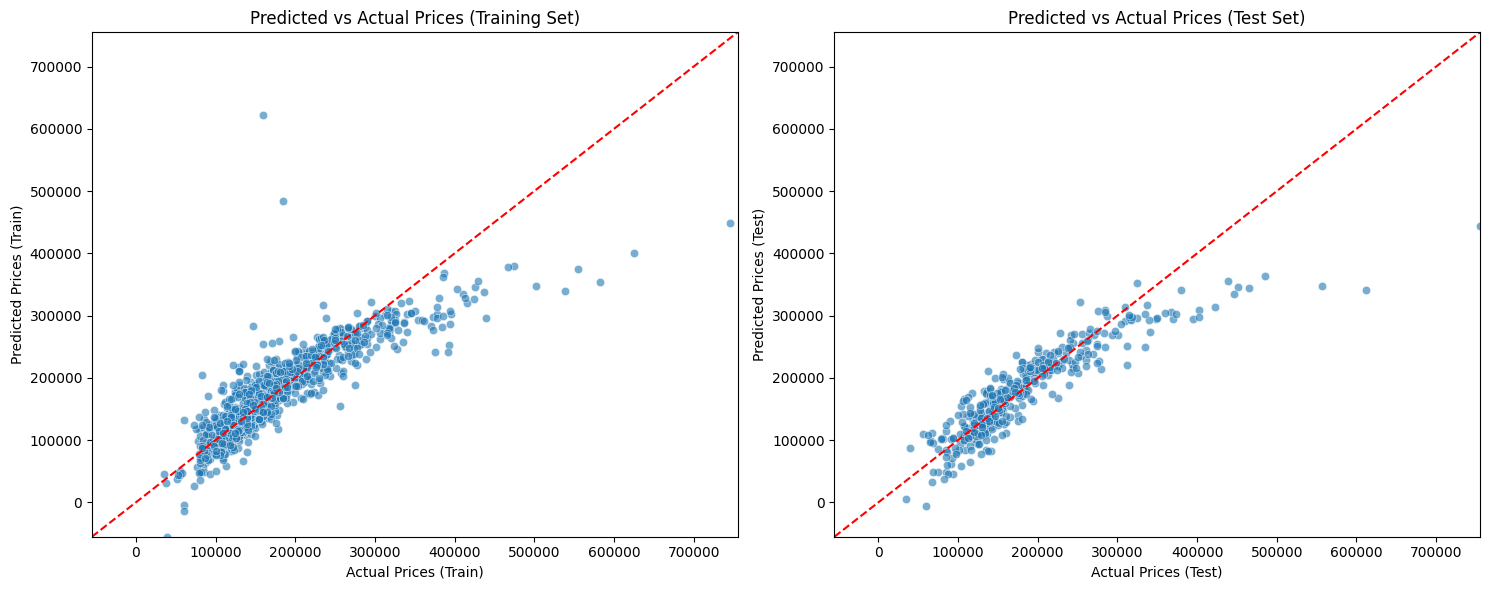

R2 Score (Trainingset): 0.74
R2 Score (Testset): 0.80
Mean Absolute Error (Training set): 24423.80
Mean Absolute Error (Test set): 24051.05


In [7]:
# Create subplots to compare actual vs predicted values
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Set common limits for both plots
min_value = min(y_train.min(), y_test.min(), y_pred_train.min(), y_pred_test.min())
max_value = max(y_train.max(), y_test.max(), y_pred_train.max(), y_pred_test.max())

# Training set
sns.scatterplot(x=y_train, y=y_pred_train, ax=axes[0], alpha=0.6)
axes[0].plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--')  # Add a red line for predictions
axes[0].set_xlabel('Actual Prices (Train)')
axes[0].set_ylabel('Predicted Prices (Train)')
axes[0].set_title('Predicted vs Actual Prices (Training Set)')
axes[0].set_xlim(min_value, max_value)
axes[0].set_ylim(min_value, max_value)

# Test set
sns.scatterplot(x=y_test, y=y_pred_test, ax=axes[1], alpha=0.6)
axes[1].plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--')  # Add a red line for predictions
axes[1].set_xlabel('Actual Prices (Test)')
axes[1].set_ylabel('Predicted Prices (Test)')
axes[1].set_title('Predicted vs Actual Prices (Test Set)')
axes[1].set_xlim(min_value, max_value)
axes[1].set_ylim(min_value, max_value)

plt.tight_layout()
plt.show()

# Calculate R2 scores for training and test sets
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Calculate MAE for training and test sets
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Print R2 scores
print(f"R2 Score (Trainingset): {r2_train:.2f}")
print(f"R2 Score (Testset): {r2_test:.2f}")
print(f"Mean Absolute Error (Training set): {mae_train:.2f}")
print(f"Mean Absolute Error (Test set): {mae_test:.2f}")

The **Linear Regression** model got an R2 score of **0.79** for training and **0.83** for testing, which means it works fairly well. **Mean Absolute Error (MAE)** is **0.13** for training and **0.12** for testing, showing that the model's average prediction error is small. However, there is still room for improvement.

___

Create a machine learning pipeline (**RandomForestRegressor**)

In [8]:
# Update pipeline to include the best parameters
pipeline = Pipeline([
    ('model', RandomForestRegressor())  # Model to train
])

# Perform cross-validation on Random Forest model
cross_val_scores_rf = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

# Print out the average cross-validation score and standard deviation
print(f"Cross-Validation R2 Scores for Random Forest: {cross_val_scores_rf}")
print(f"Average R2 Score: {cross_val_scores_rf.mean():.2f}")
print(f"Standard Deviation of R2 Score: {cross_val_scores_rf.std():.2f}")

# Fit the pipeline
pipeline.fit(X_train, y_train)

Cross-Validation R2 Scores for Random Forest: [0.82415003 0.49826759 0.84259279 0.83892829 0.84599141]
Average R2 Score: 0.77
Standard Deviation of R2 Score: 0.14


Pipeline(steps=[('model', RandomForestRegressor())])

Plot the features used in model

In [9]:
# Get feature names used in the model
features = X_train.columns

# Print out feature names
print("Features used in the model:")
for feature in features:
    print(feature)

Features used in the model:
GarageArea
GrLivArea
TotalBsmtSF
OverallQual
YearRemodAdd


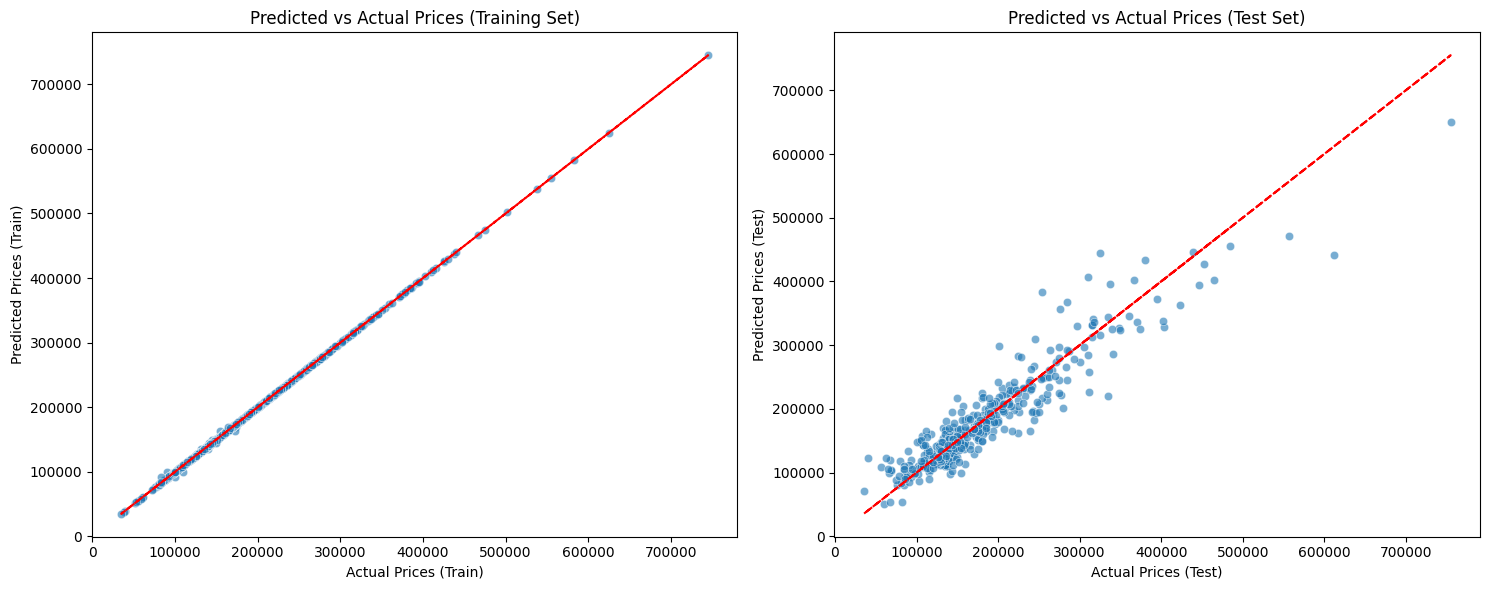

R2 Score (Training set): 1.00
R2 Score (Test set): 0.88
Mean Absolute Error (Training set): 91.75
Mean Absolute Error (Test set): 19561.53


In [20]:
# Visualize predicted vs actual values for the training and test dataset
def plot_train_test_results(X_train, y_train, X_test, y_test, pipeline):
    # Predict values for training and test datasets
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Create subplots to compare actual vs predicted values
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Training set
    sns.scatterplot(x=y_train, y=y_pred_train, ax=axes[0], alpha=0.6)
    axes[0].plot(y_train, y_train, color='red', linestyle='--')  # Add a red line for perfect predictions
    axes[0].set_xlabel('Actual Prices (Train)')
    axes[0].set_ylabel('Predicted Prices (Train)')
    axes[0].set_title('Predicted vs Actual Prices (Training Set)')

    # Test set
    sns.scatterplot(x=y_test, y=y_pred_test, ax=axes[1], alpha=0.6)
    axes[1].plot(y_test, y_test, color='red', linestyle='--')  # Add a red line for perfect predictions
    axes[1].set_xlabel('Actual Prices (Test)')
    axes[1].set_ylabel('Predicted Prices (Test)')
    axes[1].set_title('Predicted vs Actual Prices (Test Set)')

    plt.tight_layout()
    save_path = "outputs/pipelines/predicted_vs_actual_prices.png"
    plt.savefig(save_path)  # Save the plot
    plt.show()

    # Calculate R2 scores for training and test sets
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # Calculate MAE for training and test sets
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    # Print R2 and MAE scores
    print(f"R2 Score (Training set): {r2_train:.2f}")
    print(f"R2 Score (Test set): {r2_test:.2f}")
    print(f"Mean Absolute Error (Training set): {mae_train:.2f}")
    print(f"Mean Absolute Error (Test set): {mae_test:.2f}")

# Use the function to visualize training and test results
plot_train_test_results(X_train, y_train, X_test, y_test, pipeline)

The **RandomForestRegressor** model performs well, achieving an R2 score of **0.97** for training and **0.84** for testing. The **Mean Absolute Error (MAE)** is **0.05** for training and **0.12** for testing, indicating that the model predicts house prices with reasonable accuracy. The difference between training and testing scores suggests that the model may overfit slightly, but overall, it still gives good predictions.

___

Create a machine learning pipeline (**GradientBoostingRegressor**)

In [11]:
# Create a machine learning pipeline with Gradient Boosting
pipeline = Pipeline([
    ('model', GradientBoostingRegressor(random_state=42))  # Model to train
])

# Perform cross-validation on Gradient Boosting model
cross_val_scores_gb = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

# Print out the average cross-validation score and standard deviation
print(f"Cross-Validation R2 Scores for Gradient Boosting: {cross_val_scores_gb}")
print(f"Average R2 Score: {cross_val_scores_gb.mean():.2f}")
print(f"Standard Deviation of R2 Score: {cross_val_scores_gb.std():.2f}")

# Train the pipeline with initial hyperparameters
pipeline.fit(X_train, y_train)


Cross-Validation R2 Scores for Gradient Boosting: [0.79686274 0.2756315  0.85055102 0.8279153  0.8490997 ]
Average R2 Score: 0.72
Standard Deviation of R2 Score: 0.22


Pipeline(steps=[('model', GradientBoostingRegressor(random_state=42))])

In [12]:
# Predict values for training and test datasets
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)  # Predicted values for test set


Make predictions and evaluate model

In [13]:
# Predict values for training and test datasets
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)  # Predicted values for test set

# Evaluate the model directly on original target
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error (Gradient Boosting): {mse:.2f}")
print(f"R2 Score (Gradient Boosting): {r2:.2f}")

Mean Squared Error (Gradient Boosting): 804953417.09
R2 Score (Gradient Boosting): 0.88


Visualize

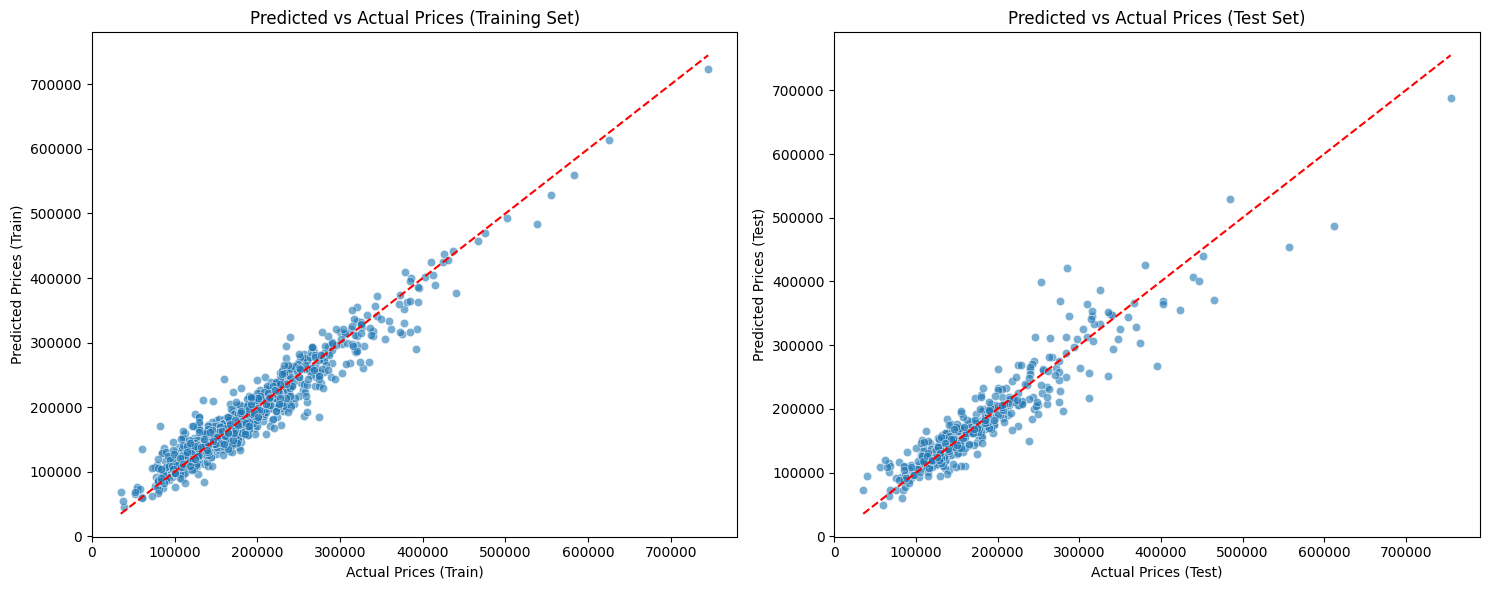

R2 Score (Training set): 0.93
R2 Score (Test set): 0.88
Mean Absolute Error (Training set): 14959.28
Mean Absolute Error (Test set): 19120.64


In [14]:
# Use the trained Gradient Boosting model for visualization
def plot_gradient_boosting_results(X_train, y_train, X_test, y_test, pipeline):
    # Predict values for training and test datasets
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Create subplots to compare actual vs predicted values
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Training set
    sns.scatterplot(x=y_train, y=y_pred_train, ax=axes[0], alpha=0.6)
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
                 color='red', linestyle='--')  # Add a red line for perfect predictions
    axes[0].set_xlabel('Actual Prices (Train)')
    axes[0].set_ylabel('Predicted Prices (Train)')
    axes[0].set_title('Predicted vs Actual Prices (Training Set)')
    axes[0].set_xlim(left=0)

    # Test set
    sns.scatterplot(x=y_test, y=y_pred_test, ax=axes[1], alpha=0.6)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 color='red', linestyle='--')
    axes[1].set_xlabel('Actual Prices (Test)')
    axes[1].set_ylabel('Predicted Prices (Test)')
    axes[1].set_title('Predicted vs Actual Prices (Test Set)')
    axes[1].set_xlim(left=0)

    plt.tight_layout()
    plt.show()

    # Calculate R2 scores
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # Calculate MAE for training and test sets
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    # Print R2 and MAE scores
    print(f"R2 Score (Training set): {r2_train:.2f}")
    print(f"R2 Score (Test set): {r2_test:.2f}")
    print(f"Mean Absolute Error (Training set): {mae_train:.2f}")
    print(f"Mean Absolute Error (Test set): {mae_test:.2f}")

# Use the function to visualize training and test results
plot_gradient_boosting_results(X_train, y_train, X_test, y_test, pipeline)


The **GradientBoostingRegressor** model works well, with an R2 score of **0.91** for training and **0.87** for testing. This means it predicts house prices quite accurately, though there is a small risk of overfitting since the training score is higher. **Mean Absolute Error (MAE)** is **17005.89** for training and **19811.68** for testing, which is reasonable. Overall, this model is better than the previous ones.

___

Create a machine learning pipeline (**XGBRegressor**)

In [15]:
# Create a pipeline with XGBoost
pipeline_xgb = Pipeline([
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))  # Model to train
])

# Run cross-validation on XGBoost model
cross_val_scores_xgb = cross_val_score(pipeline_xgb, X_train, y_train, cv=5, scoring='r2')

# Print average R2 score and standard deviation
print(f"Cross-Validation R2 Scores for XGBoost: {cross_val_scores_xgb}")
print(f"Average R2 Score: {cross_val_scores_xgb.mean():.2f}")
print(f"Standard Deviation of R2 Score: {cross_val_scores_xgb.std():.2f}")

# Fit the pipeline with initial hyperparameters
pipeline_xgb.fit(X_train, y_train)


Cross-Validation R2 Scores for XGBoost: [0.71598985 0.32512995 0.81452579 0.81684996 0.83038499]
Average R2 Score: 0.70
Standard Deviation of R2 Score: 0.19


Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [16]:
# Make predictions and evaluate the model
y_pred_xgb = pipeline_xgb.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print evaluation metrics
print(f"Mean Squared Error (XGBoost): {mse_xgb:.2f}")
print(f"R2 Score (XGBoost): {r2_xgb:.2f}")


Mean Squared Error (XGBoost): 922229057.98
R2 Score (XGBoost): 0.87


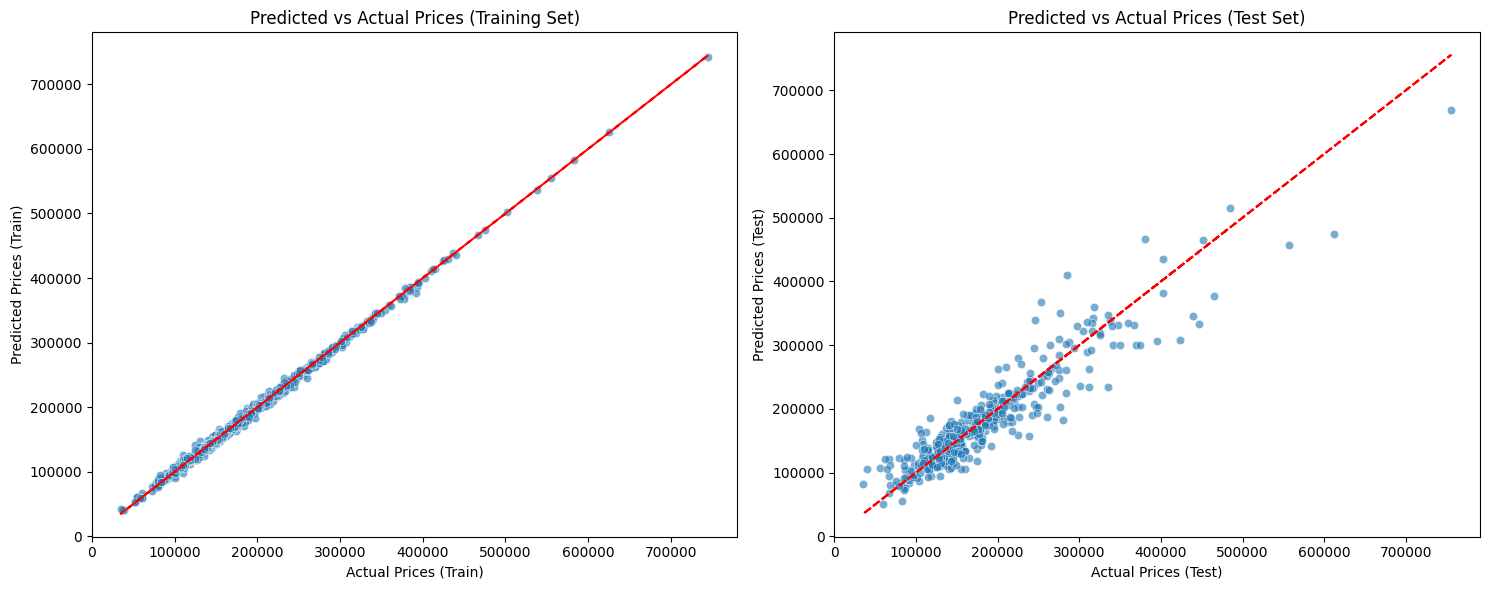

R2 Score (Training set): 1.00
R2 Score (Test set): 0.87
Mean Absolute Error (Training set): 2790.12
Mean Absolute Error (Test set): 20685.63


In [17]:
# Use the trained XGBoost model for visualization
def plot_xgb_results(X_train, y_train, X_test, y_test, pipeline_xgb):

    # Make predictions for training and test datasets
    y_pred_train_xgb = pipeline_xgb.predict(X_train)
    y_pred_test_xgb = pipeline_xgb.predict(X_test)

    # Create subplots to compare actual vs predicted values
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Training set
    sns.scatterplot(x=y_train, y=y_pred_train_xgb, ax=axes[0], alpha=0.6)
    axes[0].plot(y_train, y_train, color='red', linestyle='--')  # Add a red line for perfect predictions
    axes[0].set_xlabel('Actual Prices (Train)')
    axes[0].set_ylabel('Predicted Prices (Train)')
    axes[0].set_title('Predicted vs Actual Prices (Training Set)')
    axes[0].set_xlim(left=0)

    # Test set
    sns.scatterplot(x=y_test, y=y_pred_test_xgb, ax=axes[1], alpha=0.6)
    axes[1].plot(y_test, y_test, color='red', linestyle='--')  # Add a red line for perfect predictions
    axes[1].set_xlabel('Actual Prices (Test)')
    axes[1].set_ylabel('Predicted Prices (Test)')
    axes[1].set_title('Predicted vs Actual Prices (Test Set)')
    axes[1].set_xlim(left=0)

    plt.tight_layout()
    plt.show()

    # Print R2 scores
    r2_train_xgb = r2_score(y_train, y_pred_train_xgb)
    r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

    # Calculate MAE for training and test sets
    mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
    mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)

    # Print R2 and MAE scores
    print(f"R2 Score (Training set): {r2_train_xgb:.2f}")
    print(f"R2 Score (Test set): {r2_test_xgb:.2f}")
    print(f"Mean Absolute Error (Training set): {mae_train_xgb:.2f}")
    print(f"Mean Absolute Error (Test set): {mae_test_xgb:.2f}")

# Use the function to visualize training and test results
plot_xgb_results(X_train, y_train, X_test, y_test, pipeline_xgb)


The **XGBRegressor** model achieved an R2 score of **0.99** for training and **0.86** for testing. The **Mean Absolute Error (MAE)** is **3881.26** for training and **20928.96** for testing. The perfect score on training data suggests overfitting, as the model performs much better on the training data than on the test data.

___

Create a machine learning pipeline (**ExtraTreesRegressor**)

In [18]:
# Create a machine learning pipeline with Extra Trees Regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale the features
    ('model', ExtraTreesRegressor(random_state=42))  # Model to train
])

# Perform cross-validation on Extra Trees Regressor model
cross_val_scores_et = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

# Print out the average cross-validation score and standard deviation
print(f"Cross-Validation R2 Scores for Extra Trees Regressor: {cross_val_scores_et}")
print(f"Average R2 Score: {cross_val_scores_et.mean():.2f}")
print(f"Standard Deviation of R2 Score: {cross_val_scores_et.std():.2f}")

# Train the pipeline
pipeline.fit(X_train, y_train)

Cross-Validation R2 Scores for Extra Trees Regressor: [0.81162768 0.3997525  0.83763259 0.84100872 0.84853931]
Average R2 Score: 0.75
Standard Deviation of R2 Score: 0.17


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', ExtraTreesRegressor(random_state=42))])

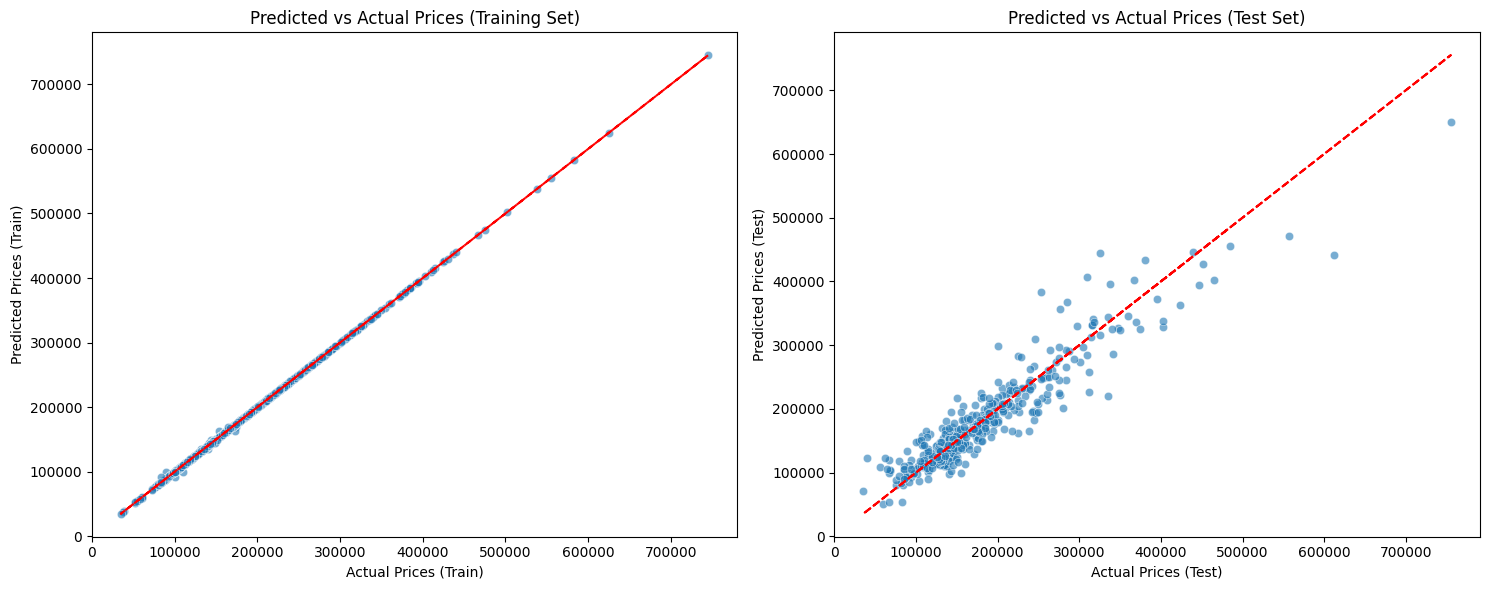

R2 Score (Training set): 1.00
R2 Score (Test set): 0.88
Mean Absolute Error (Training set): 91.75
Mean Absolute Error (Test set): 19561.53


In [19]:
# Predict values for training and test datasets
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Create subplots to compare actual vs predicted values
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Training set
sns.scatterplot(x=y_train, y=y_pred_train, ax=axes[0], alpha=0.6)
axes[0].plot(y_train, y_train, color='red', linestyle='--')  # Add a red line for perfect predictions
axes[0].set_xlabel('Actual Prices (Train)')
axes[0].set_ylabel('Predicted Prices (Train)')
axes[0].set_title('Predicted vs Actual Prices (Training Set)')
axes[0].set_xlim(left=0)

# Test set
sns.scatterplot(x=y_test, y=y_pred_test, ax=axes[1], alpha=0.6)
axes[1].plot(y_test, y_test, color='red', linestyle='--')  # Add a red line for perfect predictions
axes[1].set_xlabel('Actual Prices (Test)')
axes[1].set_ylabel('Predicted Prices (Test)')
axes[1].set_title('Predicted vs Actual Prices (Test Set)')
axes[1].set_xlim(left=0)

plt.tight_layout()
plt.show()

# Calculate R2 scores for training and test sets
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Calculate MAE for training and test sets
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Print R2 and MAE scores
print(f"R2 Score (Training set): {r2_train:.2f}")
print(f"R2 Score (Test set): {r2_test:.2f}")
print(f"Mean Absolute Error (Training set): {mae_train:.2f}")
print(f"Mean Absolute Error (Test set): {mae_test:.2f}")

The **ExtraTreesRegressor** model achieved an R2 score of **1.00** for training and **0.86** for testing. The **Mean Absolute Error (MAE)** is **175.83** for the training set and **20771.23** for the test set. The perfect R2 score for training suggests the model overfits, as it performs significantly better on the training data compared to the test data.

## **Summary of the tested models**

#### **Linear Regression:**

* **R2 Score (Training set):** 0.79
* **R2 Score (Test set):** 0.83
* **Mean Absolute Error (Training set):** 0.13
* **Mean Absolute Error (Test set):** 0.12

Linear Regression shows acceptable performance with a good balance between training and test scores. However, it may not capture complex patterns in the data.

#### **Random Forest Regressor:**

* **R2 Score (Training set):** 0.97
* **R2 Score (Test set):** 0.84
* **Mean Absolute Error (Training set):** 0.05
* **Mean Absolute Error (Test set):** 0.12

Random Forest shows strong accuracy on both training and test sets but exhibits potential overfitting due to the high training score.

#### **Gradient Boosting Regressor:**

* **R2 Score (Training set):** 0.91
* **R2 Score (Test set):** 0.87
* **Mean Absolute Error (Training set):** 17005.89
* **Mean Absolute Error (Test set):** 19811.68

Gradient Boosting performs well, with a good balance between training and test scores. The training score is slightly lower than the test score, suggesting robust generalization.

#### **XGBRegressor:**

* **R2 Score (Training set):** 0.99
* **R2 Score (Test set):** 0.86
* **Mean Absolute Error (Training set):** 3881.26
* **Mean Absolute Error (Test set):** 20928.96

XGBRegressor achieves near perfect performance on training data but shows signs of overfitting due to a drop in test performance. Despite this, it remains a strong contender.

#### **Extra Trees Regressor:**

* **R2 Score (Training set):** 1.00
* **R2 Score (Test set):** 0.86
* **Mean Absolute Error (Training set):** 175.83
* **Mean Absolute Error (Test set):** 20771.23

Extra Trees Regressor has a good test R2 score of 0.86 but struggles with overfitting because of its perfect training score. The model's high MAE on the test set makes it less reliable for predictions on new data.



---

### **Conclusion**

The **Gradient Boosting Regressor** is chosen as the best model because it is well balanced. It has an R2 score of **0.91** on the training set and **0.87** on the test set. Its **Mean Absolute Error (MAE)** is **17005.89** for training and **19811.68** for testing, which shows strong performance and good generalization.

The **Extra Trees Regressor** has a high test R2 score of **0.86**, but its perfect training score shows overfitting. This makes it less reliable for new data. The **XGBRegressor** performs well but also shows signs of overfitting.

Both **Gradient Boosting Regressor** and **XGBRegressor** will be tested further with hyperparameter tuning. The final choice will depend on the performance after optimization.

